<a href="https://colab.research.google.com/github/Faouzijedidi1/ResearchForex/blob/master/NN_for_Forex_V0_1_using_Keras_to_predict_patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import matplotlib
import numpy as np
import pandas as pd
import itertools
import sklearn
import keras
import time
import shap


from keras.models import Sequential
import keras.layers
from matplotlib import pyplot as plt
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mplfinance.original_flavor import candlestick_ohlc


print('Numpy version: ' + np.__version__)
print('Pandas version: ' + pd.__version__)
print('Matplotlib version: ' + matplotlib.__version__)
print('Sklearn version: ' + sklearn.__version__)
print('Keras version: ' + keras.__version__)

Numpy version: 1.18.5
Pandas version: 1.0.5
Matplotlib version: 3.2.2
Sklearn version: 0.22.2.post1
Keras version: 2.3.1


In [6]:
class MeasureTime:
    def __init__(self):
        self.start = time.time()
    def kill(self):
        print ('Time elapsed: ' + time.strftime("%H:%M:%S", time.gmtime(time.time()-self.start)))
        del self

In [9]:
my_dataset = pd.read_csv('EURUSD_Candlestick_1_Hour_2014-2020.csv')
my_dataset.tail()

,Local time,Open,High,Low,Close,Volume
41083,24.07.2020 20:00:00.000 GMT+0400,1.16343,1.16377,1.16287,1.16349,22046.7496
41084,24.07.2020 21:00:00.000 GMT+0400,1.16348,1.16445,1.16344,1.16406,7895.3100
41085,24.07.2020 22:00:00.000 GMT+0400,1.16406,1.16475,1.16361,1.16361,10610.1401
41086,24.07.2020 23:00:00.000 GMT+0400,1.16360,1.16422,1.16342,1.16411,7011.3300
41087,25.07.2020 00:00:00.000 GMT+0400,1.16411,1.16580,1.16407,1.16546,3845.4886


In [10]:
del my_dataset['Local time']
del my_dataset['Volume']

In [11]:
def graph_data_ohlc(dataset):
    fig = plt.figure()
    ax1 = plt.subplot2grid((1,1), (0,0))
    closep=dataset[:,[3]]
    highp=dataset[:,[1]]
    lowp=dataset[:,[2]]
    openp=dataset[:,[0]]
    date=range(len(closep))

    x = 0
    y = len(date)
    ohlc = []
    while x < y:
        append_me = date[x], openp[x], highp[x], lowp[x], closep[x]
        ohlc.append(append_me)
        x+=1
    candlestick_ohlc(ax1, ohlc, width=0.4, colorup='#77d879', colordown='#db3f3f')
    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax1.grid(True)
    plt.xlabel('Candle')
    plt.ylabel('Price')
    plt.title('Candlestick sample representation')

    plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
    plt.show()

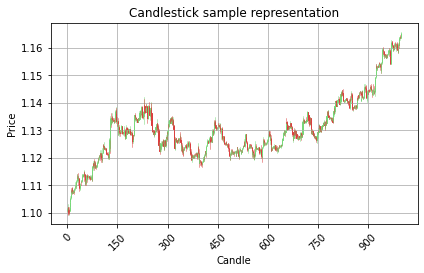

In [12]:
graph_data_ohlc(my_dataset.tail(1000).values)

In [13]:
def my_generator(data,lookback):
    final_output = []
    counter = 0
    first_row = 0
    arr = np.empty((1,lookback,4), int)
    for a in range(len(data)-lookback):
        temp_list = []
        for candle in data[first_row:first_row+lookback]:
            temp_list.append(candle)
        temp_list2 = np.asarray(temp_list)
        templist3 = [temp_list2]
        templist4 = np.asarray(templist3)
        arr = np.append(arr, templist4, axis=0)
        first_row=first_row+1
    return arr

In [14]:
cell_timer = MeasureTime()
three_dim_sequence = np.asarray(my_generator(my_dataset.values[1:],3))
cell_timer.kill()

Time elapsed: 00:00:26


In [15]:
three_dim_sequence.shape


(41085, 3, 4)

Step 1


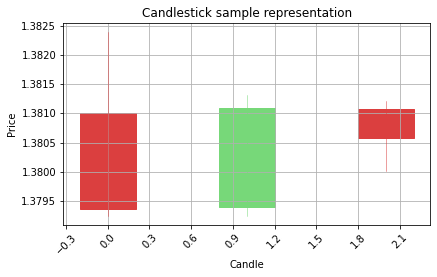

Step 2


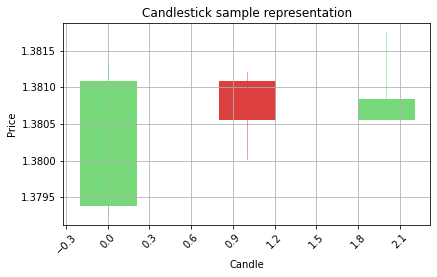

Step 3


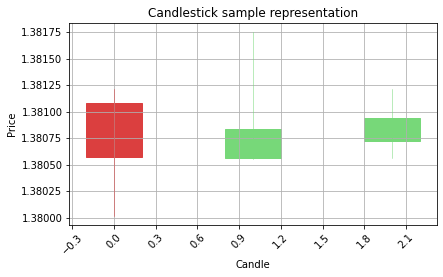

Step 4


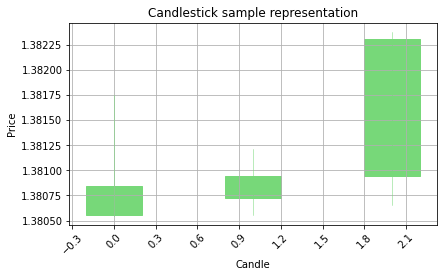

Step 5


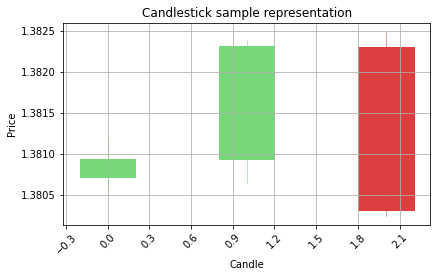

In [16]:
counter=0
for candle in three_dim_sequence[1000:1005]:
    counter=counter+1
    print('Step ' + str(counter))
    graph_data_ohlc(candle)

In [17]:
def ohlc_to_candlestick(conversion_array):
    candlestick_data = [0,0,0,0]

    if conversion_array[3]>conversion_array[0]:
        candle_type=1
        wicks_up=conversion_array[1]-conversion_array[3]
        wicks_down=conversion_array[2]-conversion_array[0]
        body_size=conversion_array[3]-conversion_array[0]

    else:
        candle_type=0
        wicks_up=conversion_array[1]-conversion_array[0]
        wicks_down=conversion_array[2]-conversion_array[3]
        body_size=conversion_array[1]-conversion_array[3]


    if wicks_up < 0:wicks_up=wicks_up*(-1)
    if wicks_down < 0:wicks_down=wicks_down*(-1)
    if body_size < 0:body_size=body_size*(-1)
    candlestick_data[0]=candle_type
    candlestick_data[1]=round(round(wicks_up,5)*10000,2)
    candlestick_data[2]=round(round(wicks_down,5)*10000,2)
    candlestick_data[3]=round(round(body_size,5)*10000,2)

    return candlestick_data

In [18]:
cell_timer = MeasureTime()
one_candle_data_ohlc=three_dim_sequence[1000:1010][5][1]
cell_timer.kill()

Time elapsed: 00:00:00


In [19]:
one_candle_data_ohlc

array([1.3823 , 1.38248, 1.38025, 1.38032])

In [20]:
one_candle_data_ohlc_candle=ohlc_to_candlestick(one_candle_data_ohlc)

In [21]:
one_candle_data_ohlc_candle

[0, 1.8, 0.7, 21.6]

In [22]:
def my_generator_candle(data,lookback):
    first_row = 0
    arr = np.empty((1,lookback,4), int)
    for a in range(len(data)-lookback):
        temp_list = []
        for candle in data[first_row:first_row+lookback]:
            converted_data = ohlc_to_candlestick(candle)
            temp_list.append(converted_data)
        temp_list2 = np.asarray(temp_list)
        templist3 = [temp_list2]
        templist4 = np.asarray(templist3)
        arr = np.append(arr, templist4, axis=0)
        first_row=first_row+1
    return arr

In [23]:
three_dim_sequence_candle=my_generator_candle(my_dataset.values[1:],3)

In [24]:
three_dim_sequence_candle[5000:5005]

array([[[ 0. ,  1.2,  2.1,  5.5],
        [ 0. , 18.4,  5.1, 21.1],
        [ 1. , 12.8,  0.3, 11.2]],

       [[ 0. , 18.4,  5.1, 21.1],
        [ 1. , 12.8,  0.3, 11.2],
        [ 0. ,  1.7,  4. , 17.8]],

       [[ 1. , 12.8,  0.3, 11.2],
        [ 0. ,  1.7,  4. , 17.8],
        [ 0. ,  4.7,  2.7, 52.2]],

       [[ 0. ,  1.7,  4. , 17.8],
        [ 0. ,  4.7,  2.7, 52.2],
        [ 0. ,  6.4,  2.5, 14. ]],

       [[ 0. ,  4.7,  2.7, 52.2],
        [ 0. ,  6.4,  2.5, 14. ],
        [ 1. ,  3.4, 10.5, 24.7]]])

In [25]:
def my_generator_candle_X_Y(data,lookback,MinMax = False):
    if MinMax==True:scaler = preprocessing.MinMaxScaler()
    first_row = 0
    arr = np.empty((0,lookback,4))
    arr3 = np.empty((0,lookback,4))
    Y_list = []
    for a in range(len(data)-lookback):
        temp_list = []
        temp_list_raw = []
        for candle in data[first_row:first_row+lookback]:
            converted_data = ohlc_to_candlestick(candle)
            temp_list.append(converted_data)
            temp_list_raw.append(candle)
        temp_list3 = [np.asarray(temp_list)]
        templist4 = np.asarray(temp_list3)

        if MinMax==True:
            templist99 = scaler.fit_transform(templist4[0])
            arr = np.append(arr, [templist99], axis=0)
        else:
            arr = np.append(arr, templist4, axis=0)

        temp_list7 = [np.asarray(temp_list_raw)]
        templist8 = np.asarray(temp_list7)
        arr3 = np.append(arr3, templist8, axis=0)

        converted_data_prediction = ohlc_to_candlestick(data[first_row+lookback])
        Prediction = converted_data_prediction[0]
        Y_list.append(Prediction)

        first_row=first_row+1

    arr2 = np.asarray(Y_list)

    return arr,arr2,arr3

In [26]:
cell_timer = MeasureTime()
X,Y, X_raw = my_generator_candle_X_Y(my_dataset.values,3,MinMax=False)
cell_timer.kill()

Time elapsed: 00:01:11


In [27]:
print('Shape of X ' + str(X.shape))
print('Shape of Y ' + str(Y.shape))
print('Shape of X raw ohlc ' + str(X_raw.shape))

Shape of X (41085, 3, 4)
Shape of Y (41085,)
Shape of X raw ohlc (41085, 3, 4)


In [28]:
unique, counts = np.unique(Y, return_counts=True)
predictions_type = dict(zip(unique, counts))
print('Bull: ' + str((predictions_type[1])) + ' percent: ' + str(round((predictions_type[1]*100)/len(Y),2)) + '%')
print('Bear: ' + str((predictions_type[0])) + ' percent: ' + str(round((predictions_type[0]*100)/len(Y),2)) + '%')
print('Total: ' + str(len(Y)))

Bull: 20381 percent: 49.61%
Bear: 20704 percent: 50.39%
Total: 41085


Correct prediction would be Bullish ---^


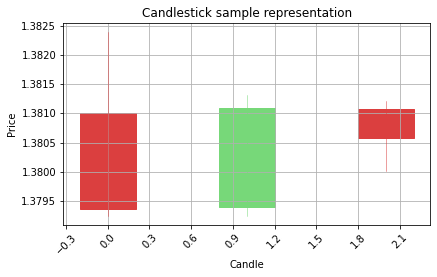

Correct prediction would be Bullish ---^


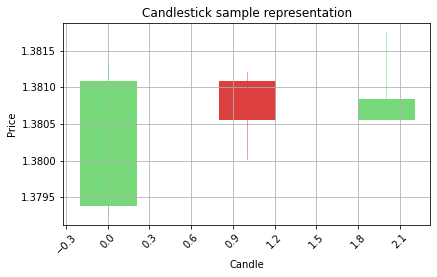

Correct prediction would be Bullish ---^


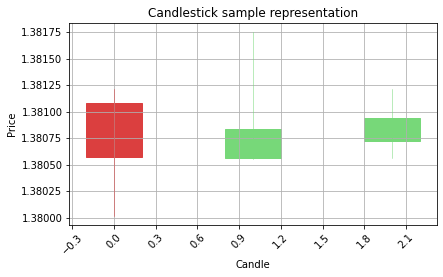

Correct prediction would be Bearish ---v


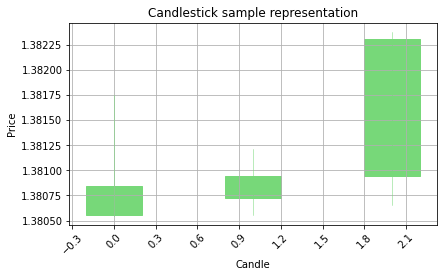

Correct prediction would be Bearish ---v


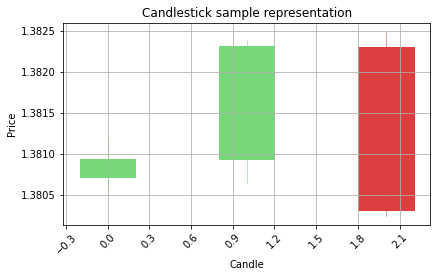

In [29]:
for a in range(5):
    b=a+1000
    if Y[b] == 1:print('Correct prediction would be Bullish ---^')
    if Y[b] == 0:print('Correct prediction would be Bearish ---v')
    graph_data_ohlc(X_raw[b])

In [30]:
from keras import layers
from keras.optimizers import RMSprop


model = Sequential()
model.add(layers.LSTM(units = 12,return_sequences=True, input_shape = (None, X.shape[-1])))
model.add(layers.LSTM(units = 24))
model.add(layers.Dense(units = 1,activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])